# Whitepaper HashCanon

In [133]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import sys
sys.path.append("..")

import importlib
import hash_utils.base_hash as base_hash
importlib.reload(base_hash)
print()

## Introduction

**HashCanon** is a philosophical and aesthetic experiment at the intersection of generative art, cryptography, and East Asian symbolism. The name blends **“hash”** (a unique digital fingerprint) with the notion of a **canon**—a structured body of knowledge that renders order from multiplicity.

A full **256-bit hash** is rendered as a **mandala of 64 radial sectors and 4 concentric layers**: one hex symbol → one sector, one bit → one layer.
For cases where only **160 bits** are available—such as Ethereum wallet or contract addresses—HashCanon shortens the circle to **40 sectors** while keeping the same 4-ring logic. Both sizes are derived from the same 256-bit mapping, so the visual grammar stays consistent.

This transformation of number into image raises questions: Can randomness become meaningful? What if we treat digital structures as modern ideograms? Where is the boundary between entropy and canon? References to the 64 hexagrams of *the I Ching* and the Daoist diagram **Wújí → Tàijí** (无极 → 太极) connect this inquiry to an ancient tradition of contemplating change.

All functions used throughout this notebook are collected in a single module:
[**`base_hash.py`**](https://github.com/HashCanon/hashcanon/blob/main/hash_utils/base_hash.py) — the central utility library for hash generation, bit manipulation, mandala construction, and feature extraction.

## 1. Hash and Randomness

### What is a Hash?

A **hash function** is a mathematical transformation that takes an input (a string, file, or data block) and produces a fixed-length fingerprint — typically 256 or 160 bits.

Key characteristics:

* It is **one-way**: it's easy to compute a hash from an input, but practically impossible to recover the input from the hash;
* It is **collision-resistant**: it’s extremely unlikely that two different inputs will produce the same hash;
* It is **sensitive to input changes**: even a single altered character will completely change the output.

Hashes are widely used in cryptography, blockchain systems (e.g., Bitcoin, Ethereum), digital signatures, and data verification.

In **HashCanon**, hashes are not just cryptographic primitives — they serve as raw material for visual pattern generation. By treating each bit as a building block of form, the system transforms invisible entropy into visible structure.

You can generate a 256-bit or 160-bit hash from any string (e.g., `"HashCanon"`) using the functions provided in the utility module [**base_hash.py**](https://github.com/HashCanon/hashcanon/blob/main/hash_utils/base_hash.py).

In [5]:
print(f"➜ SHA-256 (default): {base_hash.hash_to_hex('HashJing')}")
print(f"➜ SHA-256, truncated: {base_hash.hash_to_hex('HashJing', bits=160)}")
print(f"➜ Ethereum-style Keccak-256: {base_hash.hash_to_hex('HashJing', algo='keccak')}")
print(f"➜ Ethereum-style Keccak-160: {base_hash.hash_to_hex('HashJing', bits=160, algo='keccak')}")

➜ SHA-256 (default): 0x2b054d225d025fc24c58030bda276b16089ae21cc8aff93d2751472a98eab06c
➜ SHA-256, truncated: 0xda276b16089ae21cc8aff93d2751472a98eab06c
➜ Ethereum-style Keccak-256: 0xe302944827d82597ebdf074bb01066f8d99378130f3f6fa065a25e5fea433afd
➜ Ethereum-style Keccak-160: 0xb01066f8d99378130f3f6fa065a25e5fea433afd


### On Randomness and Security

The function `base_hash.generate_random_hash()` **relies on cryptographically secure pseudorandom number generators (CSPRNGs)**, so every output is *statistically indistinguishable from true randomness*.

* With `algo="sha256"`, entropy is **sourced with** `secrets.token_hex()`, which draws from the operating system’s CSPRNG (e.g., `/dev/urandom` on Unix-like systems).
* With `algo="keccak"`, entropy bytes are **fed into** the Keccak-256 sponge, yielding a deterministic digest from a high-entropy seed. **Keccak** is the winner of the SHA-3 competition; note that Ethereum’s `keccak256` differs slightly from NIST `SHA3-256` (padding).

Although the digest function is deterministic **given a fixed seed**, the outputs of a CSPRNG remain **computationally unpredictable unless the generator’s internal state is known**, which makes this pipeline suitable for cryptographic as well as generative-art applications.

### Hash in HashCanon

In the generative system **HashCanon**, everything begins with a **cryptographic hash** — typically a **256-bit value** rendered as 64 hexadecimal characters (often shown with `0x` prefix). Each hash serves as a unique seed for visual generation.

Cryptographic hashes possess two essential properties:

* **Determinism** — the same input always produces the same output;
* **Apparent randomness** — even a tiny change in input leads to an unpredictable, drastically different result.

This combination makes the hash an ideal bridge between number and image: it guarantees repeatability while preserving complexity and surprise.

In practice, HashCanon supports:

* **256-bit hashes** (default, e.g., SHA-256 or Keccak-256);
* **160-bit view**, which yields 40-sector mandalas — analogous in length to Ethereum addresses.
  *Implementation note:* the 160-bit view is a **truncation of the 256-bit digest** (choose a canonical policy, e.g., “take the first 160 bits”).
* **Keccak-256** (Ethereum-style `keccak256`) for Web3-native compatibility.

### Hash generation from text

In **HashCanon**, you can derive a cryptographic hash from any input string—whether it’s a meaningful phrase, a wallet address, or an emblematic word—and immediately turn that hash into a visual pattern. For example:

In [7]:
hash_hex = base_hash.hash_to_hex('HashCanon')
print(hash_hex)

0xa403e93f2190a97c22b4c161e89b820c49bbcc5ffd76d0ffef67483d7c41b530


This command produces a **256-bit SHA-256 hash** from the input `“HashCanon“`. The result is a hexadecimal string that can be directly used to generate a mandala:

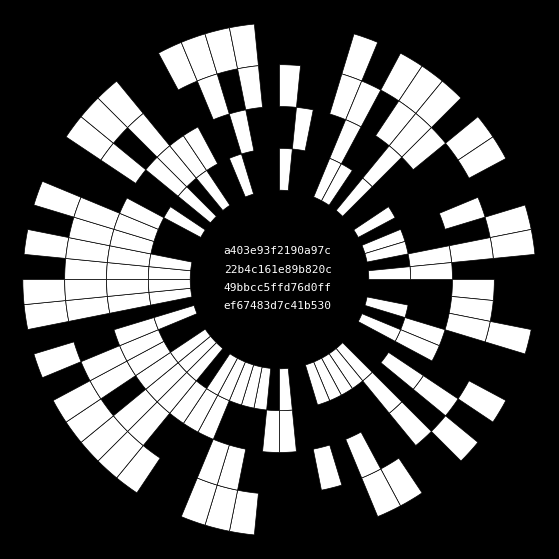

Figure 1. Mandala of the SHA-256 hash for “HashCanon“: 0xa403e93f2190a97c22b4c161e89b820c49bbcc5ffd76d0ffef67483d7c41b530



In [107]:
base_hash.draw_mandala(hash_hex)
print(f'Figure 1. Mandala of the SHA-256 hash for “HashCanon“: {hash_hex}\n')

> **Note:** The geometric rules behind this circular mandala—how bits map to rings and sectors—are outlined only briefly here. A complete, step-by-step explanation is presented in the following sections.

You can also specify the bit length or algorithm:

In [6]:
print(f"➜ 160-bit SHA-256-derived hash: {base_hash.hash_to_hex('HashCanon', bits=160)}")
print(f"➜ Ethereum-style Keccak-256 hash: {base_hash.hash_to_hex('HashCanon', algo='keccak')}")

➜ 160-bit SHA-256-derived hash: 0xe89b820c49bbcc5ffd76d0ffef67483d7c41b530
➜ Ethereum-style Keccak-256 hash: 0x23e3e8374780b3ac8a1f8bfad227acd007303a00ea51f189dd61316fe9de8428


This allows full flexibility in generating deterministic, symbolically meaningful mandalas from text.

### Why SHA-256?

We use **SHA-256** (Secure Hash Algorithm, 256-bit) because it is:

* **Widely adopted** and battle-tested in security, storage, and many blockchain contexts (e.g., Bitcoin; numerous protocols and libraries).
* Produces a **fixed 256-bit output** (64 hex characters), which maps naturally to our **4 × 64** bit mandala grid.
* **Neutral and portable**: it provides a reliable default for off-chain and cross-chain use, while **Keccak-256** is available for Ethereum-native parity.

While other algorithms exist (SHA-1, SHA-3, BLAKE2, RIPEMD-160), SHA-256 remains a de facto standard for secure, verifiable entropy and for reproducible generative pipelines.

> **Ethereum note.** Ethereum uses **Keccak-256** (often referred to as `keccak256`), which is slightly different from NIST **SHA3-256** due to padding. Our default is SHA-256 for neutrality; Keccak-256 is supported as an option for Web3-native workflows.

The resulting 64 hex characters are read as 256 bits → **64 radial sectors × 4 concentric layers** in the HashCanon visualization (1 hex → 1 sector, 1 bit → 1 ring). Thus every hex occupies a unique radial slice, and its 4 bits stack as four concentric rings inside that slice. The full mapping is detailed in the next sections.

### Where to Get Hashes in the Blockchain

| Source                                 | Usage in NFT minting / pipelines                                 | Size                |
| -------------------------------------- | ---------------------------------------------------------------- | ------------------- |
| `tokenData.hash` (Art Blocks)          | Auto-assigned per token; used as a seed in generative projects   | 256 bits (32 bytes) |
| `blockhash(n)`                         | Block-scoped seed; usable only for **recent blocks**             | 256 bits (32 bytes) |
| `keccak256(tokenId ∥ secret)`          | Deterministic seed with user salt (on-/off-chain)                | 256 bits (32 bytes) |
| `sha256`, `blake2b`, Poseidon, Rescue… | Off-chain hashing; zk-friendly options for SNARK/STARK pipelines | Typically 256 bits  |

> **Caveat:** `blockhash(n)` returns zero for **old blocks** (beyond the recent window) and is observable/manipulable within miner/validator constraints; don’t treat it as unpredictable randomness for adversarial settings.

#### Deterministic Randomness as a Mirror of Form

Hashes turn invisible entropy into visible order. The mandala reveals hidden symmetries, rhythms, and repetitions latent in raw bits — the *yīn–yáng* of digital entropy at the heart of **HashCanon**.

## 2. Binary Representation of Numbers and the Schemes of the “Book of Changes”

The *I Ching* (易經, *Yìjīng*) — the “Book of Changes” — is arguably the first known example of **binary notation** in human history.
Its “alphabet” is the **hexagram**: a vertical stack of 6 lines, where

| Line   | Symbol | Bit | Semantics                     |
| ------ | ------ | --- | ----------------------------- |
| broken | — —    | 0   | 陰 *yīn* — darkness, passivity |
| solid  | ——     | 1   | 陽 *yáng* — light, activity    |

Each hexagram is thus encoded as a number **from 0 to 63** (2⁶ = 64 combinations). The **least significant bit** is the **top** line, the **most significant** is the **bottom**.

| Line index | 0 (000000) | 1 (000001) | 2 (000010) |  …  | 62 (111110) | 63 (111111) |
| :--------: | :--------: | :--------: | :--------: | :-: | :---------: | :---------: |
|      ⑥     |     — —    |     ——     |     — —    |     |     — —     |      ——     |
|      ⑤     |     — —    |     — —    |     ——     |     |      ——     |      ——     |
|      ④     |     — —    |     — —    |     — —    |     |      ——     |      ——     |
|      ③     |     — —    |     — —    |     — —    |     |      ——     |      ——     |
|      ②     |     — —    |     — —    |     — —    |     |      ——     |      ——     |
|      ①     |     — —    |     — —    |     — —    |     |      ——     |      ——     |

**Table.** Vertical bit layouts for hexagrams in binary order. Rows ⑥ → ① represent lines from **top** (least significant bit) to **bottom** (most significant); columns show the first three and last two hexagrams of the 0–63 range. `——` denotes a *yáng* line (1), `— —` a *yīn* line (0); `…` indicates omitted intermediate columns.

![Circular arrangement of 64 hexagrams](pic/yi_circle.jpg)

**Figure 2.** Circular arrangement of the 64 hexagrams (binary order)

**Circular diagram of the 64 hexagrams in ascending binary order.**
The starting point is **Kūn** `000000` at the top. Moving clockwise, we add **1** to the six-bit number with each step: `000001`, `000010`, … until the cycle closes at **Qián** `111111`. Black = *yīn* (0), white = *yáng* (1).
This **ascending order** matches the way HashCanon fills its 64 sectors.

### From Hexagrams to HashCanon

HashCanon takes the same idea of binary motifs and applies it to a modern **256-bit hash** (SHA-256 / Keccak-256):

```
0x87a797a48cba94ee585ee2c0d7d6f4cce4dd12f77192a4d0bc562938d6fb62b1
```

* 64 hex characters → **64 sectors** of the mandala;
* each hex = 4 bits → **4 concentric layers** (from center to periphery).

Thus emerges a natural bridge between cryptographic randomness and the binary cosmology of the *I Ching*: instead of six stacked lines we now read four nested rings, yet the mapping **“least significant bit → innermost layer”** mirrors the classical idea that genesis starts at the base and unfolds outward.

## 3. The Principle of Diagram Construction

HashCanon interprets a 256-bit hash as **64 hexadecimal characters**.
Each hex character → **4 bits** → one radial sector with **4 concentric cells**.

### ▸ Binary Decomposition

*Each hex character is explicitly mapped to its 4 bits **from least significant to most significant** (LSB → inner ring, … → MSB → outer ring). The **sector order** is 0…63, starting at the top and proceeding clockwise. This convention also applies to the 160-bit view (40 sectors × 4 rings).*

In [10]:
my_hash = base_hash.generate_random_hash()
print(f'my_hash = {my_hash}\n')
base_hash.explain_hex_to_bin(my_hash)

my_hash = 0x167fbe681c74996d324aad56345207154d72a00d9e91974fd4399ee38a4a982d

00: 1 -> 0001
01: 6 -> 0110
02: 7 -> 0111
03: F -> 1111
04: B -> 1011
05: E -> 1110
06: 6 -> 0110
07: 8 -> 1000
08: 1 -> 0001
09: C -> 1100
10: 7 -> 0111
11: 4 -> 0100
12: 9 -> 1001
13: 9 -> 1001
14: 6 -> 0110
15: D -> 1101
16: 3 -> 0011
17: 2 -> 0010
18: 4 -> 0100
19: A -> 1010
20: A -> 1010
21: D -> 1101
22: 5 -> 0101
23: 6 -> 0110
24: 3 -> 0011
25: 4 -> 0100
26: 5 -> 0101
27: 2 -> 0010
28: 0 -> 0000
29: 7 -> 0111
30: 1 -> 0001
31: 5 -> 0101
32: 4 -> 0100
33: D -> 1101
34: 7 -> 0111
35: 2 -> 0010
36: A -> 1010
37: 0 -> 0000
38: 0 -> 0000
39: D -> 1101
40: 9 -> 1001
41: E -> 1110
42: 9 -> 1001
43: 1 -> 0001
44: 9 -> 1001
45: 7 -> 0111
46: 4 -> 0100
47: F -> 1111
48: D -> 1101
49: 4 -> 0100
50: 3 -> 0011
51: 9 -> 1001
52: 9 -> 1001
53: E -> 1110
54: E -> 1110
55: 3 -> 0011
56: 8 -> 1000
57: A -> 1010
58: 4 -> 0100
59: A -> 1010
60: 9 -> 1001
61: 8 -> 1000
62: 2 -> 0010
63: D -> 1101


### ▸ Rectangular Unfolding

**Figure 3** shows how the function `base_hash.draw_binary_grid_from_hex(my_hash)` unfolds the hash into a linear ribbon read **left to right** (the function accepts hex with or without the `0x` prefix).

* 4 rows × 64 columns
* **Top = least significant bit**, bottom = most significant bit
* ◻️ white = 1 (*yáng*), ◼️ black = 0 (*yīn*)
* Red vertical lines split the ribbon into **4 blocks of 16 hex characters** — the same “quarters” that will later form the mandala

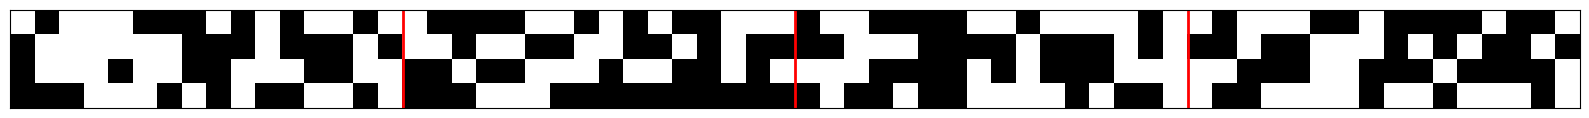

Figure 3. Rectangular 4 × 64 binary ribbon produced from the hash: 0x167fbe681c74996d324aad56345207154d72a00d9e91974fd4399ee38a4a982d



In [11]:
base_hash.draw_binary_grid_from_hex(my_hash)
print(f'Figure 3. Rectangular 4 × 64 binary ribbon produced from the hash: {my_hash}\n')

### ▸ Circular Mandala

Below is the function `base_hash.draw_mandala(my_hash)`, which generates a circular mandala based on the principles described above. The linear ribbon displays the hash “as is,” while the mandala represents the same sequence of bits folded into a circle of 64 sectors and 4 layers. This transformation reveals the symmetry and rhythm hidden in the 256-bit number while maintaining strict determinism: one hash → one form.

* The 64 sectors are arranged **clockwise**, starting at the 12 o’clock position. A red radial line highlights the starting point.
* In each sector, the concentric cells from center to outer edge represent bits `b0 → b1 → b2 → b3`.
* White = 1 (*yáng*), black = 0 (*yīn*).
* The original hash is shown in the center, split into 4 lines × 16 characters — making it easy to match text to visual.

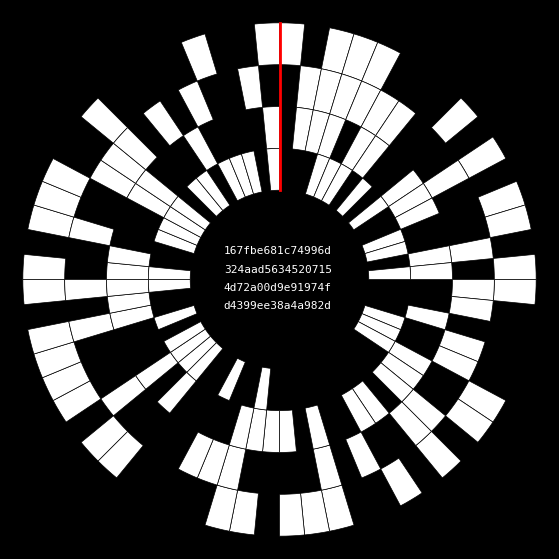

Figure 4. Circular mandala generated from the hash: 0x167fbe681c74996d324aad56345207154d72a00d9e91974fd4399ee38a4a982d



In [108]:
base_hash.draw_mandala(my_hash, show_radial_line=True)
print(f'Figure 4. Circular mandala generated from the hash: {my_hash}\n')

#### ▸ Addresses as Hashes (160 bit)

In addition to 256-bit hashes, **HashCanon** can also transform **Ethereum addresses** — wallet or smart contract addresses — into mandalas. Visually, these are 40 hex characters; in essence, they represent a truncated fragment of a Keccak-256 hash, totaling **160 bits**.

Since `base_hash.draw_mandala()` accepts any length divisible by 4, for an address we simply specify `sectors = 40`:

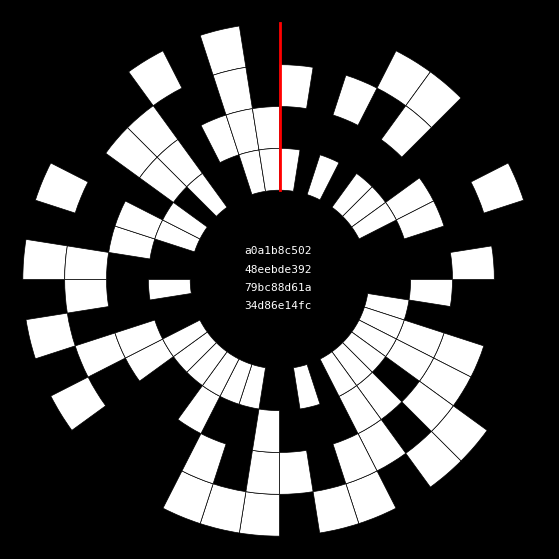

Figure 5. Circular mandala generated from the hash: 0xa0a1b8c50248eebde39279bc88d61a34d86e14fc



In [14]:
my_hash_160 = base_hash.generate_random_hash(bits=160)
base_hash.draw_mandala(my_hash_160, sectors=40, show_radial_line=True)
print(f'Figure 5. Circular mandala generated from the hash: {my_hash_160}\n')

The algorithm remains the same: each hex character produces four concentric cells, so the address appears as **40 radial sectors × 4 rings**. This allows any on-chain object — whether a wallet, contract, or NFT — to be “signed” with a mandala, while preserving HashCanon’s core principle: **one hash → one unique form**.

## 4. Features of Order

This section explores properties inherent in the circular mandalas that reveal structural order. These patterns are not imposed externally; they emerge spontaneously from the discrete entropy of the hash.

### 4.1 Balanced Mandala

A hash of *even* length **n** bits is called **balanced** when it contains exactly **n/2** ones and **n/2** zeros.

*Example A* For a **256-bit** hash, “balanced” means 128 ones and 128 zeros. In a sample of **10,000 randomly generated 256-bit hashes** produced with `secrets.token_hex(32)`, such mandalas appeared in **≈5%** of cases.

*Example B* For a **160-bit** hash (e.g., an Ethereum address), balance requires 80 ones and 80 zeros. The theoretical probability is **≈6%**, which matches the empirical share in a **10,000-hash** sample.

These numbers show that perfectly balanced mandalas are statistically rare, yet they emerge naturally from pure entropy.

Below are examples of balanced mandalas derived from both 256-bit and 160-bit hashes.

#### Balanced 256-bit Hash

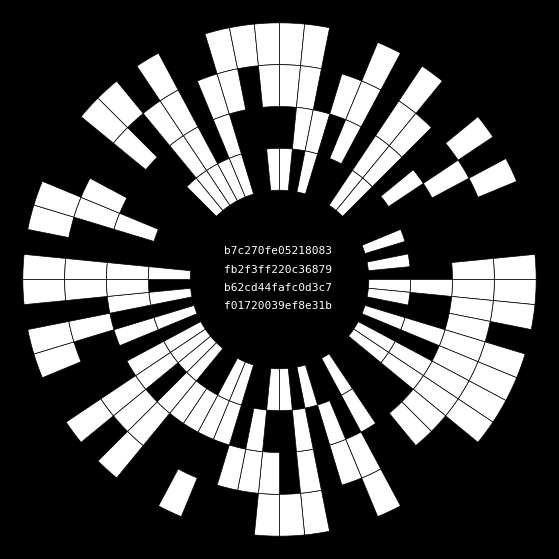

Figure 6. Balanced mandala from a 256-bit hash: 0xb7c270fe05218083fb2f3ff220c36879b62cd44fafc0d3c7f01720039ef8e31b



In [15]:
balanced_hash_256 = base_hash.generate_balanced_hash()
base_hash.draw_mandala(balanced_hash_256)
print(f'Figure 6. Balanced mandala from a 256-bit hash: {balanced_hash_256}\n')

In [16]:
print(
    "Zero/one ratio for the sample 256-bit hex string "
    f'"{balanced_hash_256}" = {base_hash.bit_ratio(balanced_hash_256)}'
)
print("(For a balanced hash, this ratio should equal 1.00)")
print(f"Balance check → is_balanced: {base_hash.is_balanced(balanced_hash_256)}\n")

Zero/one ratio for the sample 256-bit hex string "0xb7c270fe05218083fb2f3ff220c36879b62cd44fafc0d3c7f01720039ef8e31b" = 1.00
(For a balanced hash, this ratio should equal 1.00)
Balance check → is_balanced: True



#### Balanced 160-bit Hash

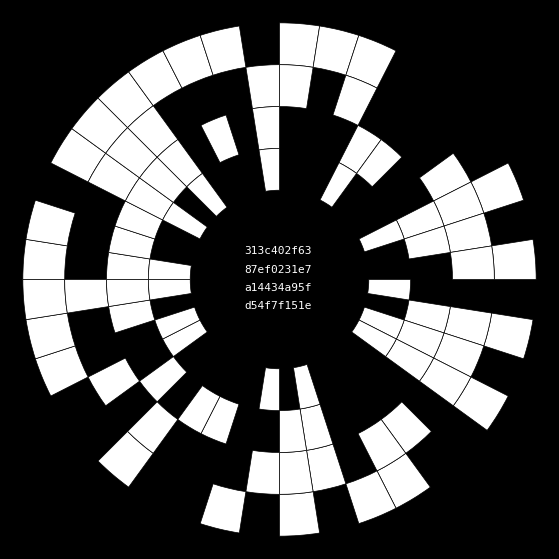

Figure 7. Balanced mandala from 160-bit hash: 0x313c402f6387ef0231e7a14434a95fd54f7f151e



In [20]:
balanced_hash_160 = base_hash.generate_balanced_hash(bits=160)
base_hash.draw_mandala(balanced_hash_160, sectors=40)
print(f'Figure 7. Balanced mandala from 160-bit hash: {balanced_hash_160}\n')

In [21]:
print(
    "Zero/one ratio for the sample 160-bit hex string "
    f'"{balanced_hash_160}" = {base_hash.bit_ratio(balanced_hash_160)}'
)
print("(For a balanced hash, this ratio should equal 1.00)")
print(f"Balance check → is_balanced: {base_hash.is_balanced(balanced_hash_160)}\n")

Zero/one ratio for the sample 160-bit hex string "0x313c402f6387ef0231e7a14434a95fd54f7f151e" = 1.00
(For a balanced hash, this ratio should equal 1.00)
Balance check → is_balanced: True



#### Theoretical probability

For a random binary string of even length (n), the chance of being perfectly balanced is
[
P ;=; \frac{\binom{n}{n/2}}{2^{n}}.
]

* **256 bits:** (P \approx 4.98%)
* **160 bits** (Ethereum addresses): (P \approx 6.30%)

Thus, perfectly balanced mandalas are rare yet statistically inevitable—an equilibrium that emerges naturally from randomness.

### 4.2 Passages and Sealed Structures in the Mandala

Most mandalas exhibit one or more **passages** — continuous paths from the inner ring to the outer ring formed entirely by zeros (black cells). These passages can be interpreted as escape routes through the labyrinth that a hypothetical observer could follow outward.

Each passage is **isolated by impassable walls of ones** (white cells), which break connectivity between paths and prevent crossovers.

A **sealed mandala** is a special case where none of the inner-ring cells provide any route to the outside. No passage connects the center to the edge — even indirectly. It is essentially an *airtight labyrinth*, completely enclosed by “white walls”.

Such structures are exceedingly rare: out of **10,000** randomly generated 256-bit hashes (via `secrets.token_hex(32)`), only about **0.07%** (7 out of 10,000) resulted in sealed mandalas.

#### 4.2.1 Single-Passage Hash

As an example, consider mandalas with exactly one passage:

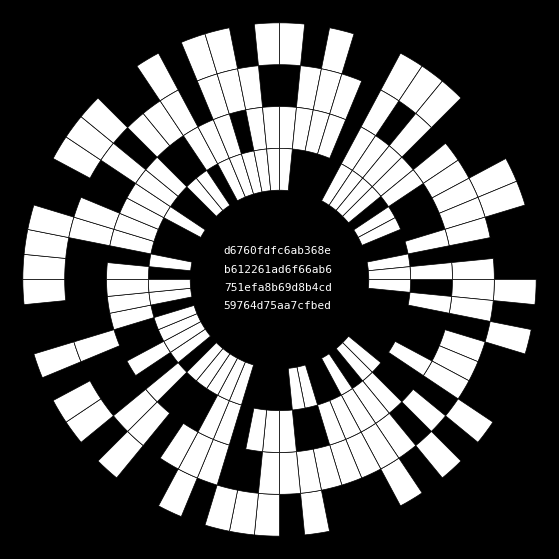

Figure 8. Single-passage mandala from 256-bit hash: 0xd6760fdfc6ab368eb612261ad6f66ab6751efa8b69d8b4cd59764d75aa7cfbed



In [27]:
single_passage_hash_256 = base_hash.generate_hash_with_passages(target_passages=1)
base_hash.draw_mandala(single_passage_hash_256)
print(f'Figure 8. Single-passage mandala from 256-bit hash: {single_passage_hash_256}\n')

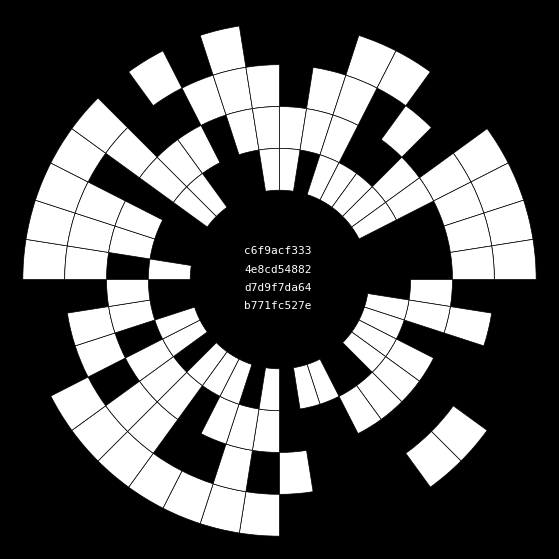

Figure 9. Single-passage mandala from 160-bit hash: 0xc6f9acf3334e8cd54882d7d9f7da64b771fc527e



In [28]:
single_passage_hash_160 = base_hash.generate_hash_with_passages(target_passages=1, bits=160)
base_hash.draw_mandala(single_passage_hash_160, sectors=40)
print(f'Figure 9. Single-passage mandala from 160-bit hash: {single_passage_hash_160}\n')

#### 4.2.2 Determining the Number of Passages in a Mandala Generated from a Random Hash

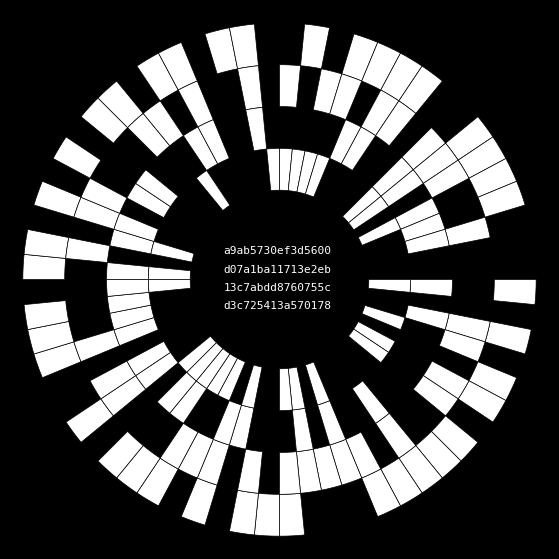

Figure 10. Mandala with 5 passages generated from a random 256-bit hash



In [55]:
random_hash_256 = base_hash.generate_random_hash()
base_hash.draw_mandala(random_hash_256)
print(f'Figure 10. Mandala with {base_hash.count_unique_passages(random_hash_256)} passages generated from a random 256-bit hash\n')

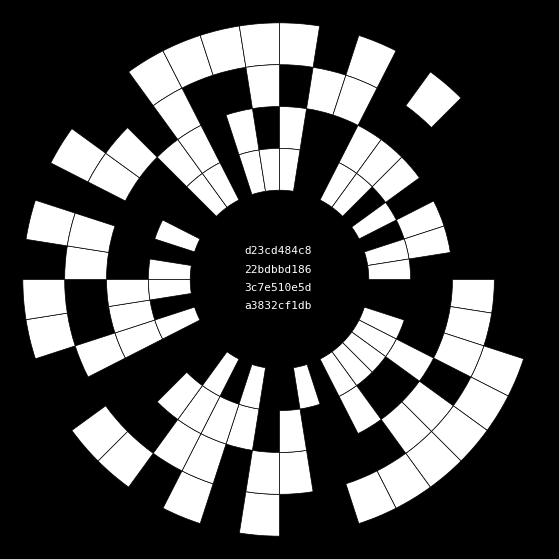

Figure 11. Mandala with 4 passages generated from a random 160-bit hash



In [30]:
random_hash_160 = base_hash.generate_random_hash(bits=160)
base_hash.draw_mandala(random_hash_160, sectors=40)
print(f'Figure 11. Mandala with {base_hash.count_unique_passages(random_hash_160)} passages generated from a random 160-bit hash\n')

#### 4.2.3 Sealed Mandala
Below are examples of *sealed* mandalas generated from 256-bit and 160-bit hashes, respectively:

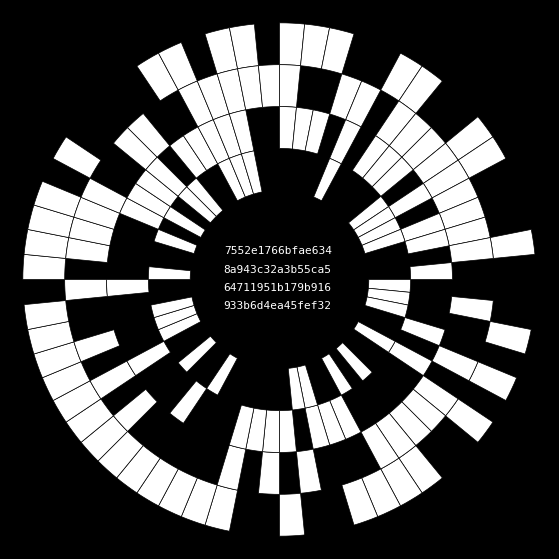

Figure 12. Sealed Mandala, generated from a random 256-bit hash: "0x7552e1766bfae6348a943c32a3b55ca564711951b179b916933b6d4ea45fef32"



In [31]:
sealed_hash_256 = base_hash.generate_hash_with_passages(target_passages=0)
base_hash.draw_mandala(sealed_hash_256)
print(f'Figure 12. Sealed Mandala, generated from a random 256-bit hash: "{sealed_hash_256}"\n')

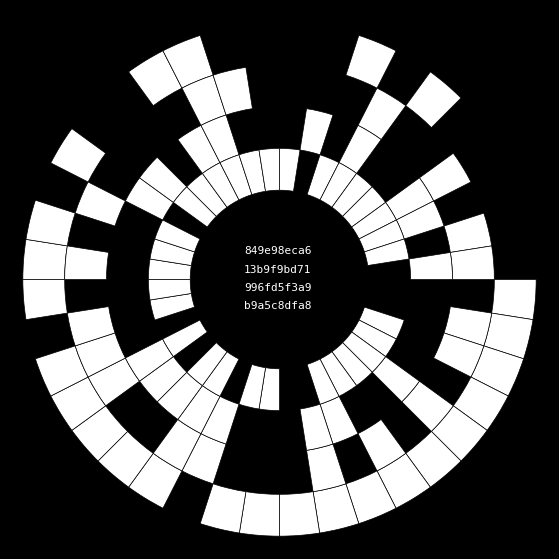

Figure 13. Sealed Mandala, generated from a random 160-bit hash: "0x849e98eca613b9f9bd71996fd5f3a9b9a5c8dfa8"



In [32]:
sealed_hash_160 = base_hash.generate_hash_with_passages(target_passages=0, bits=160)
base_hash.draw_mandala(sealed_hash_160, sectors=40)
print(f'Figure 13. Sealed Mandala, generated from a random 160-bit hash: "{sealed_hash_160}"\n')

#### 4.2.4 Distribution of Passage Counts

This section examines the statistical distribution of **radial passage** counts in mandalas derived from random hashes. A passage is a connected path of black (0-bit) cells that leads from the inner ring to the outer ring. By generating large batches of hashes and counting the number of **unique** passages in each mandala, we can see how often **sealed** (0 passages), **single-path** (1 passage), or **highly porous** (many passages) structures occur.

**Histograms 1** and **2** present the passage-count distributions for **256-bit** and **160-bit** hashes, respectively.

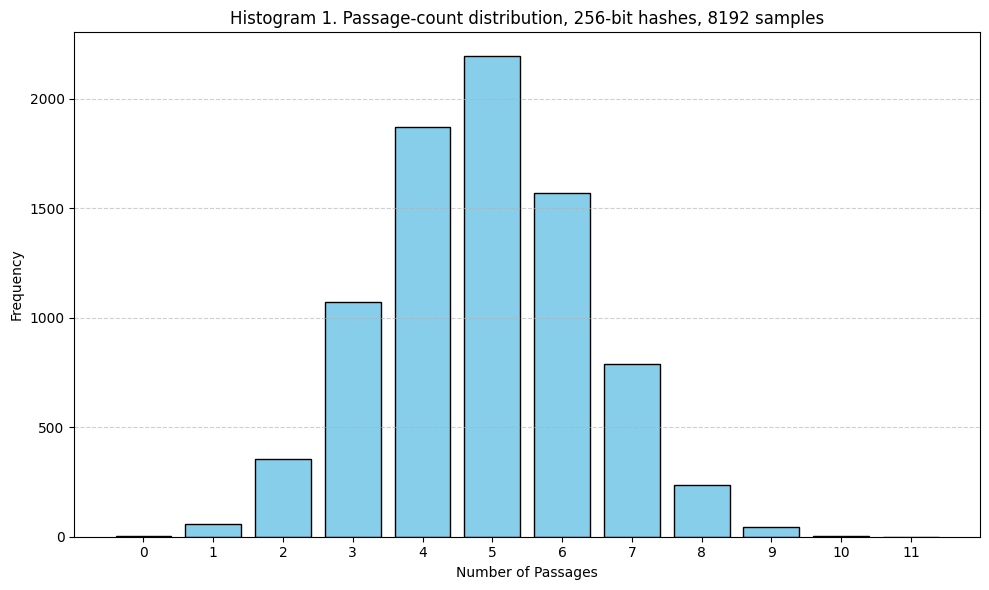

Counter({5: 2193, 4: 1869, 6: 1567, 3: 1073, 7: 789, 2: 356, 8: 236, 1: 57, 9: 44, 0: 4, 10: 3, 11: 1})


In [48]:
# 256-bit sample
sample_size = 8192
bit_length = 256
distribution = base_hash.passage_distribution(sample_size, bits=bit_length)
counter = Counter(distribution)

# Plotting the histogram
df = pd.DataFrame.from_dict(counter, orient='index').sort_index()
df.columns = ['Frequency']
df.index.name = 'Number of Passages'

plt.figure(figsize=(10, 6))
plt.bar(df.index, df['Frequency'], color='skyblue', edgecolor='black')
plt.title(f"Histogram 1. Passage-count distribution, 256-bit hashes, {sample_size} samples")
plt.xlabel("Number of Passages")
plt.ylabel("Frequency")
plt.xticks(range(min(df.index), max(df.index)+1))
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
print(counter)

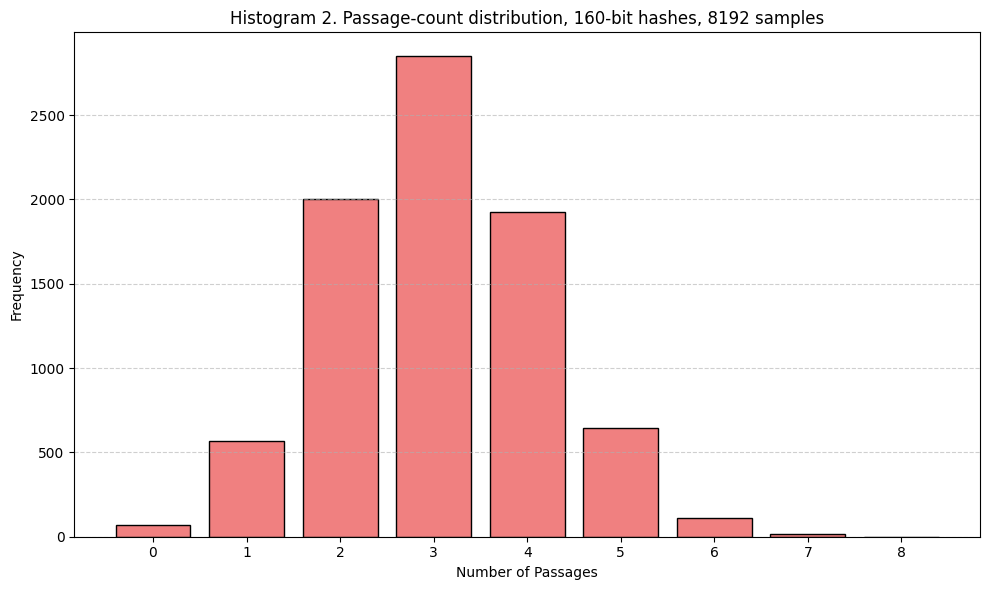

Counter({3: 2848, 2: 2004, 4: 1927, 5: 645, 1: 569, 6: 110, 0: 69, 7: 19, 8: 1})


In [49]:
# 160-bit sample
sample_size = 8192
bit_length = 160
distribution = base_hash.passage_distribution(sample_size, bits=bit_length)
counter = Counter(distribution)

# Plotting the histogram
df = pd.DataFrame.from_dict(counter, orient='index').sort_index()
df.columns = ['Frequency']
df.index.name = 'Number of Passages'

plt.figure(figsize=(10, 6))
plt.bar(df.index, df['Frequency'], color='lightcoral', edgecolor='black')
plt.title(f"Histogram 2. Passage-count distribution, 160-bit hashes, {sample_size} samples")
plt.xlabel("Number of Passages")
plt.ylabel("Frequency")
plt.xticks(range(min(df.index), max(df.index)+1))
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
print(counter)

### 4.3 Simulated Joint Distribution

In this section, we simulate a random collection of **8,192 mandalas** derived from uniformly distributed 256-bit hashes. We choose a sample size of **8,192 (2¹³)**—a power of two and a multiple of **256**—to align with the binary structure of the model and enable neat stratification (e.g., exactly **32** hashes for each sector index modulo 256), while keeping computation lightweight.

For each hash, we extract two structural features:

* `num_passages`: the number of radial escape paths (distinct zero-connected routes from center to edge);
* `is_balanced`: a boolean flag indicating whether the hash contains exactly **128** zeros and **128** ones (a **balanced mandala**).

The following table presents the raw dataset used in this simulation.
Each row corresponds to a single hash and its computed properties, which form the basis for the aggregated analysis in the next section. Note that, with a sample of this size, extreme outcomes (e.g., *sealed* mandalas with `num_passages = 0`) may appear a handful of times—or not at all—purely due to sampling variability.


In [50]:
df = base_hash.generate_hash_dataframe(n = 8192, bits = 256)
display(
    df.head().style
      .set_caption("Table A. Raw sample: hash, balance flag, passage count")
)

,hash,is_balanced,num_passages
0,0xf2868b033a13a8066e2151f2793b072683e50c7dcd4c55be11aebbbf685e283d,False,5
1,0xe7797c3c54aaca8c45c379b370941c71ea05a8722e251d72a96282117a9df9bd,False,3
2,0x3e9c8c5f2f1179a80b059ffcb489c1bf74ec65d14cfad853b726300db55b8858,False,5
3,0xbe72a904c75ae660c90ad3f28ac5d99a61a2b8754ed62a9e1e76c27e98c69d30,False,5
4,0x07fd8826b8301673357051b3608af5c515e7a64fed4a47c3a71fee7c1a386b1e,False,5


#### 4.3.1 Aggregated Table: Passage Count vs. Bit Balance

The table below summarizes the simulation results:

* `total_hashes` — number of hashes observed for each value of `num_passages`;
* `balanced_count` — how many of those hashes also satisfy the **balanced mandala** criterion.

This aggregation estimates how often passage structure and bit balance co-occur in purely random data.


In [51]:
# Group by number of passes with column reordering
aggregation = (
    df.groupby("num_passages")
      .agg(
          total_hashes=("hash", "count"),
          balanced_count=("is_balanced", "sum")
      )
      .reset_index()[["num_passages", "total_hashes", "balanced_count"]]
)

# Print the result
display(
    aggregation.style
        .set_caption(
            "Table B. Total hashes and balanced-hash counts per passage class"
        )
)

,num_passages,total_hashes,balanced_count
0,0,3,0
1,1,62,0
2,2,337,11
3,3,1060,49
4,4,1938,116
5,5,2218,123
6,6,1550,79
7,7,753,44
8,8,231,8
9,9,36,3


#### Commentary

* The passage-count distribution is centered around **4–6 passages**, reflecting the typical structural openness of a mandala.
* **Balanced mandalas** occur more frequently within this central range.
* **Sealed** mandalas (`num_passages = 0`) remain extremely rare.
* **Very porous** mandalas (`num_passages ≥ 9`) constitute the thin upper tail of the distribution.

These results quantify the structural expectations for hash-based mandalas and highlight how infrequently extreme configurations occur.


### 4.3 Symmetries (Circular Palindromes)

В мандале **симметрия** — это локальный зеркальный узор вдоль окружности: для некоторого подряд идущего набора секторов ([start,,start+length-1]) (с учётом циклического перехода) биты во **всех четырёх кольцах** читаются одинаково слева направо и справа налево. Проще: участок является **круговым палиндромом** одновременно для всех 4 колец.

Мы считаем **все** такие участки длиной ≥ 2, а затем оставляем только **максимальные** (не вложенные в более длинные). Итоговое представление состоит из:

* списка симметрий `[(start, length, slice)]`;
* агрегата **Ranks**: частоты по длинам (например: `2:3, 3:6`);
* сводной метрики: **`9 total | Ranks: 2:3, 3:6`** (в примере 9 симметрий всего).

На визуализации:

1. красные радиальные линии — границы палиндромов;
2. полупрозрачные **серые** секторы — все найденные палиндромы;
3. полупрозрачные **красные** секторы — только **максимальные** палиндромы.

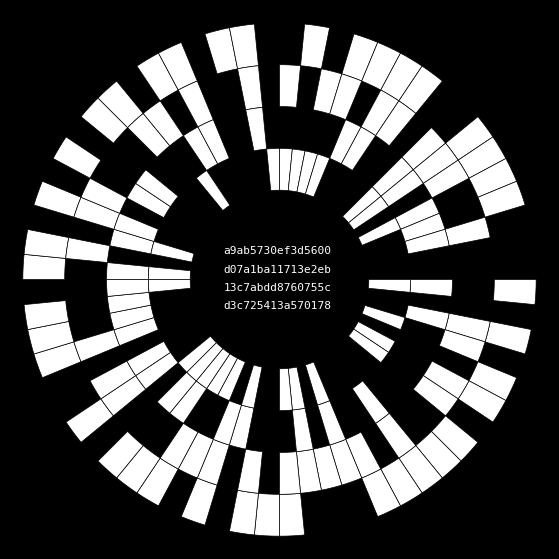

0xa9ab5730ef3d5600d07a1ba11713e2eb13c7abdd8760755cd3c725413a570178


In [65]:
base_hash.draw_mandala(random_hash_256)
print(random_hash_256)

In [62]:
base_hash.symmetry_metric(random_hash_256)

'8 total | Ranks: 2:4, 3:4'

In [64]:
base_hash.find_symmetries(random_hash_256)

[(0, 3, 'a9a'),
 (14, 2, '00'),
 (15, 3, '0d0'),
 (23, 2, '11'),
 (24, 3, '171'),
 (28, 3, 'e2e'),
 (38, 2, 'dd'),
 (45, 2, '55')]

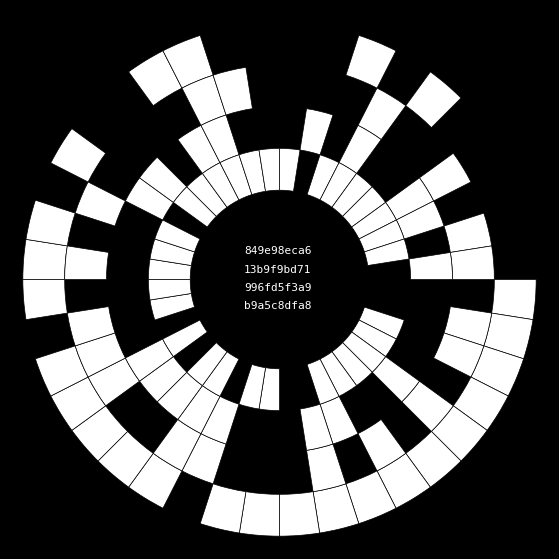

0xd23cd484c822bdbbd1863c7e510e5da3832cf1db


In [66]:
base_hash.draw_mandala(sealed_hash_160, sectors=40)
print(random_hash_160)

In [59]:
base_hash.symmetry_metric(random_hash_160, bits=160)

'6 total | Ranks: 2:1, 3:4, 4:1'

In [58]:
base_hash.find_symmetries(random_hash_160, bits=160)

[(5, 3, '484'),
 (10, 2, '22'),
 (12, 3, 'bdb'),
 (13, 4, 'dbbd'),
 (31, 3, '383'),
 (38, 3, 'dbd')]

In [68]:
syms_160 = base_hash.find_symmetries(random_hash_160, bits=160)
base_hash.symmetry_ranks(syms_160)   # e.g. {2: 3, 3: 6}

{2: 1, 3: 4, 4: 1}

In [72]:
syms_256 = base_hash.find_symmetries(random_hash_256, bits=256)
ov = base_hash.symmetry_overlay_segments(syms_256, sectors=64)
# ov['boundaries'], ov['all_spans'], ov['max_spans']
ov

{'boundaries': [(0, 3),
  (14, 16),
  (15, 18),
  (23, 25),
  (24, 27),
  (28, 31),
  (38, 40),
  (45, 47)],
 'all_spans': [(0, 3),
  (14, 2),
  (15, 3),
  (23, 2),
  (24, 3),
  (28, 3),
  (38, 2),
  (45, 2)],
 'max_spans': [(0, 3), (15, 3), (24, 3), (28, 3)]}

Crown (для симметрий): по твоему описанию — это «максимальная симметрия и её количество» в виде строки L:K (например, 4:1) плюс список всех максимальных. Я добавил две функции:

In [93]:
base_hash.crown_from_symmetries(sym_list)
base_hash.crown_metric(hex_str, bits)

NameError: name 'sym_list' is not defined

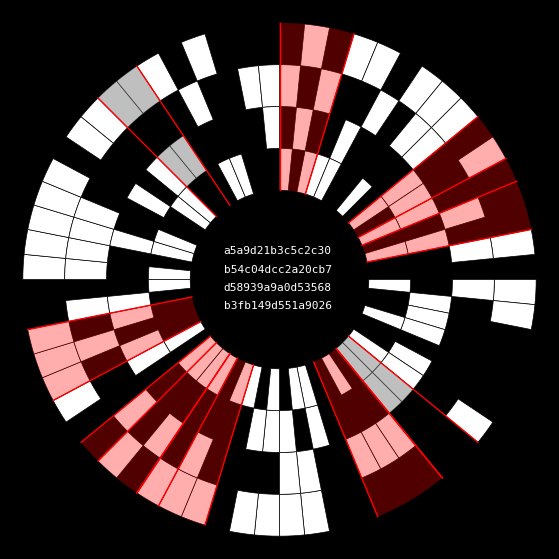

0xa5a9d21b3c5c2c30b54c04dcc2a20cb7d58939a9a0d53568b3fb149d551a9026


In [135]:
test_hash = base_hash.generate_random_hash(bits=256)
base_hash.draw_mandala(test_hash, symmetry_overlay_segments=True) 
print(test_hash)

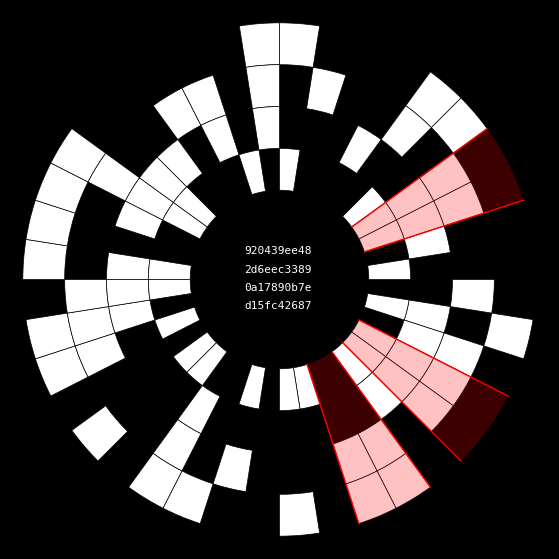

0x920439ee482d6eec33890a17890b7ed15fc42687


In [130]:
test_hash = base_hash.generate_random_hash(bits=160)
base_hash.draw_mandala(test_hash, sectors=40, symmetry_overlay_segments=True) 
print(test_hash)

## Community & Support

[![Join the discussion](https://img.shields.io/github/discussions/DataSattva/HashCanon?logo=github)](https://github.com/DataSattva/HashCanon/discussions)

Questions, ideas or bug reports?  
Open a thread in [**HashCanon Discussions**](https://github.com/DataSattva/HashCanon/discussions) and let’s talk!

For a detailed list of HashCanon contacts and resources, see the page [**Contacts and Resources**](https://datasattva.github.io/HashCanon-res/).